# Question 13
In this notebook we address question 3 of Lab5+6. For this purpose we will explore the data over years to confirm or nuance the observations we made on year 1994. We will then gather more data, data about the airports (state and zip code), about the planes,  daily weather data (at airports) and maybe more.

# Part 3
# Period 1993-1996, data exploration

In [119]:
import os
import sys
import re
from pyspark import SparkContext
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
import time as time

from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.util import MLUtils
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import RandomForest, RandomForestModel

# to start testing, we can focus on a single year
base = "/datasets/airline/"
# base = "/Users/quentinleroy/Documents/Eurecom/AML/Lab5+6/air_delays/"
raw_data = sc.textFile(base + "1994.csv")
#raw_data_1993 = sc.textFile(base + "1993.csv")
#raw_data_1994 = sc.textFile(base + "1994.csv")
#raw_data_1995 = sc.textFile(base + "1995.csv")
#raw_data_1996 = sc.textFile(base + "1996.csv")

In [65]:
#raw_data = raw_data_1993.union(raw_data_1994).union(raw_data_1995).union(raw_data_1996)

In [120]:
# extract the header
header = raw_data.first()

def deleteNA(row):
    line = row.split(",")
    for (i,col) in enumerate(line):
        if col=='NA':
            line[i]=''
    return ','.join(line)

# replace invalid data with NULL and remove header
cleaned_data = (raw_data\
        # filter out the header
        .filter(lambda row: row!=header)
        # replace the missing values with empty characters
        .map(lambda row: deleteNA(row))
        )
        
#print("number of rows after cleaning:", raw_data.count())

In [121]:
sqlContext = SQLContext(sc)
# Declare the data schema
# see http://stat-computing.org/dataexpo/2009/the-data.html
# for more information
airline_data_schema = StructType([ \
    #StructField( name, dataType, nullable)
    StructField("year",                     IntegerType(), True), \
    StructField("month",                    IntegerType(), True), \
    StructField("day_of_month",             IntegerType(), True), \
    StructField("day_of_week",              IntegerType(), True), \
    StructField("departure_time",           IntegerType(), True), \
    StructField("scheduled_departure_time", IntegerType(), True), \
    StructField("arrival_time",             IntegerType(), True), \
    StructField("scheduled_arrival_time",   IntegerType(), True), \
    StructField("carrier",                  StringType(),  True), \
    StructField("flight_number",            StringType(),  True), \
    StructField("tail_number",              StringType(), True), \
    StructField("actual_elapsed_time",      IntegerType(), True), \
    StructField("scheduled_elapsed_time",   IntegerType(), True), \
    StructField("air_time",                 IntegerType(), True), \
    StructField("arrival_delay",            IntegerType(), True), \
    StructField("departure_delay",          IntegerType(), True), \
    StructField("src_airport",              StringType(),  True), \
    StructField("dest_airport",             StringType(),  True), \
    StructField("distance",                 IntegerType(), True), \
    StructField("taxi_in_time",             IntegerType(), True), \
    StructField("taxi_out_time",            IntegerType(), True), \
    StructField("cancelled",                StringType(),  True), \
    StructField("cancellation_code",        StringType(),  True), \
    StructField("diverted",                 StringType(),  True), \
    StructField("carrier_delay",            IntegerType(), True), \
    StructField("weather_delay",            IntegerType(), True), \
    StructField("nas_delay",                IntegerType(), True), \
    StructField("security_delay",           IntegerType(), True), \
    StructField("late_aircraft_delay",      IntegerType(), True)\
])

In [122]:
# convert each line into a tuple of features (columns)

cleaned_data_to_columns = cleaned_data.map(lambda l: l.split(","))\
    .map(lambda cols: (
            int(cols[0])  if cols[0] else None,
            int(cols[1])  if cols[1] else None,
            int(cols[2])  if cols[2] else None,
            int(cols[3])  if cols[3] else None,
            int(cols[4])  if cols[4] else None,
            int(cols[5])  if cols[5] else None,
            int(cols[6])  if cols[6] else None,
            int(cols[7])  if cols[7] else None,
            cols[8]       if cols[8] else None,
            cols[9]       if cols[9] else None,
            cols[10]      if cols[10] else None,
            int(cols[11]) if cols[11] else None,
            int(cols[12]) if cols[12] else None,
            int(cols[13]) if cols[13] else None,
            int(cols[14]) if cols[14] else None,
            int(cols[15]) if cols[15] else None,
            cols[16]      if cols[16] else None,
            cols[17]      if cols[17] else None,
            int(cols[18]) if cols[18] else None,
            int(cols[19]) if cols[19] else None,
            int(cols[20]) if cols[20] else None,
            cols[21]      if cols[21] else None,
            cols[22]      if cols[22] else None,
            cols[23]      if cols[23] else None,
            int(cols[24]) if cols[24] else None,
            int(cols[25]) if cols[25] else None,
            int(cols[26]) if cols[26] else None,
            int(cols[27]) if cols[27] else None,
            int(cols[28]) if cols[28] else None
         ))

In [123]:
# create dataframe df
df = (sqlContext.createDataFrame(cleaned_data_to_columns, schema = airline_data_schema)
        .select(["year", "month", "day_of_month", "day_of_week", \
                "departure_time", "scheduled_departure_time","arrival_time",\
                 "scheduled_arrival_time","arrival_delay", "departure_delay",\
                 "src_airport", "dest_airport", "carrier", "distance", "tail_number"])
        .cache()
    )

# print("number of rows before cleaning:", df.count())

In [124]:
total_flights = df.count()
print("During period 1995, among ", total_flights, " flights")
print("\t", df[df.departure_delay>120].count(), "flights departed more than 120 minutes late")
print("\t", df[df.departure_delay<-10].count(), "flight departed more than 10 minutes early")
print("\t", df[df.arrival_delay>120].count(), "flights arrived more than 120 minutes late")
print("\t", df[df.arrival_delay<-10].count(), "flight arrived more than 10 minutes early")

During period 1995, among  5180048  flights
	 31063 flights departed more than 120 minutes late
	 3778 flight departed more than 10 minutes early
	 37987 flights arrived more than 120 minutes late
	 560869 flight arrived more than 10 minutes early


In [125]:
df = df.filter(~df.year.isNull())
df = df.filter(~df.month.isNull())
df = df.filter(~df.day_of_month.isNull())
df = df.filter(~df.day_of_week.isNull())
df = df.filter(~df.departure_time.isNull())
df = df.filter(~df.arrival_time.isNull())
df = df.filter(~df.scheduled_arrival_time.isNull())
df = df.filter(~df.arrival_delay.isNull())
df = df.filter(~df.departure_delay.isNull())
df = df.filter(~df.src_airport.isNull())
df = df.filter(~df.dest_airport.isNull())
df = df.filter(~df.carrier.isNull())
df = df.filter(~df.distance.isNull())
# df = df.filter(~df.tail_number.isNull())

## Add some columns

In [126]:
def time_to_minutes(hour_minutes):
    hour = round(hour_minutes/100, 0)
    minutes = hour_minutes - 100*hour
    return 60*hour + minutes

In [127]:
df = df.withColumn('hour', round(df.scheduled_departure_time/100, 0))
df = df.withColumn('is_delay', when(df["arrival_delay"] >= 15, 1).otherwise(0))
df = df.withColumn("scheduled_departure_minutes", time_to_minutes(df.scheduled_departure_time))
df = df.withColumn("scheduled_arrival_minutes", time_to_minutes(df.scheduled_arrival_time))
df = df.withColumn("is_WedThuFri", when((df["day_of_week"]>=3) & (df["day_of_week"]<=5), 1).otherwise(0))
df = df.withColumn("is_weekend", when((df["day_of_week"]>=6) & (df["day_of_week"]<=7), 1).otherwise(0))
df = df.withColumn("air_delay", df.arrival_delay-df.departure_delay)

# Some work about the airports

In [128]:
src_airports = df.select("src_airport").distinct().collect()
dest_airports = df.select("dest_airport").distinct().collect()
src_airports.sort()
dest_airports.sort()
src_airports = [iata.src_airport for iata in src_airports]
dest_airports = [iata.dest_airport for iata in dest_airports]

In [129]:
import csv
# airports_filename = "/Users/quentinleroy/Documents/Eurecom/AML/Lab5+6/data/airports.csv"
airports_filename = "/user/group07/airports.csv"
airports_data = sc.textFile(airports_filename)
header_airports = airports_data.first()
airports_clean_data = airports_data.filter(lambda row: row!=header_airports).map(lambda row: deleteNA(row))

airport_data_schema = StructType([
        StructField("src_airport_iata", StringType(), True),
        StructField("dest_airport_iata", StringType(), True),
        StructField("src_airport", StringType(), True),
        StructField("dest_airport", StringType(), True),
        StructField("src_airport_city", StringType(), True), 
        StructField("dest_airport_city", StringType(), True), 
        StructField("src_airport_state", StringType(), True),
        StructField("dest_airport_state", StringType(), True),
        StructField("src_airport_country", StringType(), True),
        StructField("dest_airport_country", StringType(), True),
        StructField("src_airport_lat", FloatType(), True),
        StructField("dest_airport_lat", FloatType(), True),
        StructField("src_airport_long", FloatType(), True),
        StructField("dest_airport_long", FloatType(), True)
    ])

airports_clean_data_to_columns = airports_clean_data.map(lambda l: list(csv.reader([l]))[0])\
    .map(lambda cols: (cols[0] if cols[0] else None,
                       cols[0] if cols[0] else None,
                       cols[1] if cols[1] else None,
                       cols[1] if cols[1] else None, 
                       cols[2] if cols[2] else None, 
                       cols[2] if cols[2] else None,
                       cols[3] if cols[3] else None,
                       cols[3] if cols[3] else None,
                       cols[4] if cols[4] else None,
                       cols[4] if cols[4] else None,
                       float(cols[5]) if cols[5] else None,
                       float(cols[5]) if cols[5] else None,
                       float(cols[6]) if cols[6] else None,
                       float(cols[6]) if cols[6] else None
        ))
    
df_airports = sqlContext.createDataFrame(airports_clean_data_to_columns, schema=airport_data_schema).cache()

df_src_airports = df_airports.select(["src_airport_iata", "src_airport_city", "src_airport_state", 
                                      "src_airport_country", "src_airport_lat", "src_airport_long"])
df_dest_airports = df_airports.select(["dest_airport_iata", "dest_airport_city", "dest_airport_state", 
                                      "dest_airport_country", "dest_airport_lat", "dest_airport_long"])

df_src_airports = df_src_airports.filter(df_src_airports.src_airport_iata.isin(src_airports))
df_dest_airports = df_dest_airports.filter(df_dest_airports.dest_airport_iata.isin(dest_airports))

df = df.join(df_src_airports, df.src_airport==df_src_airports.src_airport_iata)
df = df.join(df_dest_airports, df.dest_airport==df_dest_airports.dest_airport_iata)

In [130]:
df = df.filter(~df.src_airport_state.isNull())
df = df.filter(~df.dest_airport_state.isNull())

# Working with plane data

In [131]:
plane_data_filename = "/user/group07/plane-data-n_number-type_aircraft-type_engine.csv"
planes_data = sc.textFile(plane_data_filename)
header_plane_data = planes_data.first()
planes_clean_data = planes_data.filter(lambda row: row!=header_plane_data).map(lambda row: deleteNA(row))

plane_data_schema = StructType([
        StructField("n_number", StringType(), True),
        StructField("type_aircraft", IntegerType(), True),
        StructField("type_engine", IntegerType(), True),
    ])

planes_clean_data_to_columns = planes_clean_data.map(lambda l: list(csv.reader([l]))[0])\
    .map(lambda cols: ("N"+cols[0].strip() if cols[0] else None,
                       int(cols[1]) if cols[1] else None,
                       int(cols[2]) if cols[2] else None,
                       
        ))
    
df_planes = sqlContext.createDataFrame(planes_clean_data_to_columns, schema=plane_data_schema).cache()
df = df.join(df_planes, on=df.tail_number==df_planes.n_number, how='left')

# Working with severe weather data
The state in the following csv file is not specified as a code ("Alabama" instead of "AL"), load states_codes.csv before and then join with storm_events

In [132]:
states_codes_filename = "/user/group07/states_codes.csv"
# states_codes_filename= "/Users/quentinleroy/Documents/Eurecom/Algorithmic-Machine-Learning/data/states_codes.csv"
states_codes_data = sc.textFile(states_codes_filename)
header_states_codes = states_codes_data.first()
states_codes_clean_data = states_codes_data.filter(lambda row: row!=header_states_codes)

states_codes_data_schema = StructType([
        StructField("state", StringType(), True),
        StructField("state_code", StringType(), True)
    ])

states_codes_clean_data_to_columns = states_codes_clean_data.map(lambda l: list(csv.reader([l]))[0])\
    .map(lambda cols: ( cols[0].upper() if cols[0] else None,
                        cols[1] if cols[1] else None,
                       ))
    
df_states_codes = sqlContext.createDataFrame(states_codes_clean_data_to_columns, schema=states_codes_data_schema)

In [133]:
map_month_name_to_month = {"JAN": 1, "FEB": 2, "MAR": 3, "APR": 4, "MAY": 5, "JUN": 6, "JUL": 7, "AUG": 8,
                          "SEP": 9, "OCT": 10, "NOV": 11, "DEC": 12}

def date_time_parse_before_2000(date_time):
    front = date_time.split(" ")[0]
    back = date_time.split(" ")[1]
    year = int("19"+front.split("-")[2]) # year
    month = map_month_name_to_month[front.split("-")[1]] #month
    day_of_month = int(front.split("-")[0]) #day_of_month
    hour = int(back.split(":")[0]) #hour
    minute = int(back.split(":")[1]) #minute
    return {"year": year, "month": month, "day_of_month": day_of_month, 
            "hour": hour, "minute": minute, "minutes": hour*60+minute}


In [134]:
import csv
storm_event_filename = "/user/group07/storm_events.csv"
# storm_event_filename = "/Users/quentinleroy/Documents/Eurecom/Algorithmic-Machine-Learning/data/storm_events.csv"
storm_events_data = sc.textFile(storm_event_filename)
header_storm_event_data = storm_events_data.first()
storm_events_clean_data = storm_events_data.filter(lambda row: row!=header_storm_event_data).map(lambda row: deleteNA(row))

"""storm_event_data_schema = StructType([
        StructField("begin_yearmonth", StringType(), True), # important 0 
        StructField("begin_day", StringType(), True), # important 1
        StructField("begin_time", StringType(), True), # important 2
        StructField("end_yearmonth", StringType(), True), # important 3
        StructField("end_day", StringType(), True), # important 4
        StructField("end_time", StringType(), True), # important 5
        StructField("episode_id", StringType(), True),
        StructField("event_id", StringType(), True),
        StructField("state", StringType(), True), # important 6
        StructField("state_fips", StringType(), True),
        StructField("year", StringType(), True), # important 7
        StructField("month_name", StringType(), True), # important 8
        StructField("event_type", StringType(), True),
        StructField("cz_type", StringType(), True),
        StructField("cz_fips", StringType(), True),
        StructField("cz_name", StringType(), True),
        StructField("wfo", StringType(), True),
        StructField("begin_date_time", StringType(), True), # important 9
        StructField("cz_timezone", StringType(), True),
        StructField("end_date_time", StringType(), True), # important 10
        StructField("injuries_direct", StringType(), True),
        StructField("injuries_indirect", StringType(), True),
        StructField("deaths_direct", StringType(), True),
        StructField("deaths_indirect", StringType(), True),
        StructField("damage_property", StringType(), True),
        StructField("damage_crops", StringType(), True),
        StructField("source", StringType(), True),
        StructField("magnitude", StringType(), True), # important 11
        StructField("magnitude_type", StringType(), True),
        StructField("flood_cause", StringType(), True),
        StructField("category", StringType(), True), # important 12
        StructField("tor_f_scale", StringType(), True),
        StructField("tor_length", StringType(), True),
        StructField("tor_width", StringType(), True),
        StructField("tor_other_wfo", StringType(), True),
        StructField("tor_other_cz_state", StringType(), True),
        StructField("tor_other_cz_fips", StringType(), True),
        StructField("tor_other_cz_name", StringType(), True),
        StructField("begin_range", StringType(), True),
        StructField("begin_azimuth", StringType(), True),
        StructField("begin_location", StringType(), True),
        StructField("end_range", StringType(), True),
        StructField("end_azimuth", StringType(), True),
        StructField("end_location", StringType(), True),
        StructField("begin_lat", StringType(), True), # important 13
        StructField("begin_lon", StringType(), True), # important 14
        StructField("end_lat", StringType(), True), # important 15
        StructField("end_lon", StringType(), True), # # important 16
        StructField("episode_narrative", StringType(), True),
        StructField("event_narrative", StringType(), True),
        StructField("data_source", StringType(), True)
    ])"""

storm_event_data_schema = StructType([
        StructField("state", StringType(), True), 
        StructField("event_type", StringType(), True),
        StructField("begin_year", IntegerType(), True), 
        StructField("begin_month", IntegerType(), True), 
        StructField("begin_day_of_month", IntegerType(), True), 
        StructField("begin_minutes", IntegerType(), True), 
        StructField("end_year", IntegerType(), True), 
        StructField("end_month", IntegerType(), True), 
        StructField("end_day_of_month", IntegerType(), True), 
        StructField("end_minutes", IntegerType(), True), 
        StructField("magnitude", StringType(), True), 
        StructField("magnitude_type", StringType(), True)
    ])
storm_events_clean_data_to_columns = storm_events_clean_data.map(lambda l: list(csv.reader([l]))[0])\
    .map(lambda cols: ( cols[8] if cols[8] else None, # state
                        cols[12] if cols[12] else None, # event_type
                        date_time_parse_before_2000(cols[17])["year"] if cols[17] else None, # begin_year
                        date_time_parse_before_2000(cols[17])["month"] if cols[17] else None, # begin_month
                        date_time_parse_before_2000(cols[17])["day_of_month"] if cols[17] else None, # begin_day_of_month
                        date_time_parse_before_2000(cols[17])["minutes"] if cols[17] else None, # begin_minutes
                        date_time_parse_before_2000(cols[19])["year"] if cols[19] else None, # end_year
                        date_time_parse_before_2000(cols[19])["month"] if cols[19] else None, # end_month
                        date_time_parse_before_2000(cols[19])["day_of_month"] if cols[19] else None, # end_day_of_month
                        date_time_parse_before_2000(cols[19])["minutes"] if cols[19] else None, # end_minutes
                        float(cols[27]) if cols[27] else None, #magnitude
                        float(cols[28]) if cols[28] else None  #magnitude_type
                      ))

"""storm_events_clean_data_to_columns = storm_events_clean_data.map(lambda l: list(csv.reader([l]))[0])\
    .map(lambda cols: ( cols[0] if cols[0] else None,
                        cols[1] if cols[1] else None,
                        cols[2] if cols[2] else None,
                        cols[3] if cols[3] else None,
                        cols[4] if cols[4] else None,
                        cols[5] if cols[5] else None,
                        cols[6] if cols[6] else None,
                        cols[7] if cols[7] else None,
                        cols[8] if cols[8] else None,
                        cols[9] if cols[9] else None,
                        cols[10] if cols[10] else None,
                        cols[11] if cols[11] else None,
                        cols[12] if cols[12] else None,
                        cols[13] if cols[13] else None,
                        cols[14] if cols[14] else None,
                        cols[15] if cols[15] else None,
                        cols[16] if cols[16] else None,
                        cols[17] if cols[17] else None,
                        cols[18] if cols[18] else None,
                        cols[19] if cols[19] else None,
                        cols[20] if cols[20] else None,
                        cols[21] if cols[21] else None,
                        cols[22] if cols[22] else None,
                        cols[23] if cols[23] else None,
                        cols[24] if cols[24] else None,
                        cols[25] if cols[25] else None,
                        cols[26] if cols[26] else None,
                        cols[27] if cols[27] else None,
                        cols[28] if cols[28] else None,
                        cols[29] if cols[29] else None,
                        cols[30] if cols[30] else None,
                        cols[31] if cols[31] else None,
                        cols[32] if cols[32] else None,
                        cols[33] if cols[33] else None,
                        cols[34] if cols[34] else None,
                        cols[35] if cols[35] else None,
                        cols[36] if cols[36] else None,
                        cols[37] if cols[37] else None,
                        cols[38] if cols[38] else None,
                        cols[39] if cols[39] else None,
                        cols[40] if cols[40] else None,
                        cols[41] if cols[41] else None,
                        cols[42] if cols[42] else None,
                        cols[43] if cols[43] else None,
                        cols[44] if cols[44] else None,
                        cols[45] if cols[45] else None,
                        cols[46] if cols[46] else None,
                        cols[47] if cols[47] else None,
                        cols[48] if cols[48] else None,
                        cols[49] if cols[49] else None,
                        cols[50] if cols[50] else None
                       
        ))"""
    
df_storm_events = sqlContext.createDataFrame(storm_events_clean_data_to_columns, schema=storm_event_data_schema).cache()

# Finally join df_storm_events and df_states_codes on state
df_storm_events = df_storm_events.join(df_states_codes, on=(df_storm_events.state==df_states_codes.state))

In [101]:
df_storm_events.first()

Row(state='CONNECTICUT', event_type='Thunderstorm Wind', begin_year=1994, begin_month=5, begin_day_of_month=6, begin_minutes=769, end_year=1994, end_month=5, end_day_of_month=6, end_minutes=769, magnitude='0.0', magnitude_type=None, state='CONNECTICUT', state_code='CT')

In [89]:
df_storm_events.count()

15616

In [99]:
df.print

## Join df with df_storm_events on {src,dest}_airport_state and day of year (year, month, day_of_month)

In [135]:
cond = [df.src_airport_state==(df_storm_events.state_code),\
        df.year==(df_storm_events.begin_year), \
        df.month==(df_storm_events.begin_month), \
        df.day_of_month==(df_storm_events.begin_day_of_month)]

In [ ]:
df_with_storm_events.first()

Row(year=1994, month=4, day_of_month=6, day_of_week=3, departure_time=1048, scheduled_departure_time=1050, arrival_time=1117, scheduled_arrival_time=1127, arrival_delay=-10, departure_delay=-2, src_airport='JNU', dest_airport='SIT', carrier='AS', distance=95, tail_number=None, hour=11.0, is_delay=0, scheduled_departure_minutes=610.0, scheduled_arrival_minutes=687.0, is_WedThuFri=1, is_weekend=0, air_delay=-8, src_airport_iata='JNU', src_airport_city='Juneau', src_airport_state='AK', src_airport_country='USA', src_airport_lat=58.35496139526367, src_airport_long=-134.57627868652344, dest_airport_iata='SIT', dest_airport_city='Sitka', dest_airport_state='AK', dest_airport_country='USA', dest_airport_lat=57.04713821411133, dest_airport_long=-135.36160278320312, n_number=None, type_aircraft=None, type_engine=None, state=None, event_type=None, begin_year=None, begin_month=None, begin_day_of_month=None, begin_minutes=None, end_year=None, end_month=None, end_day_of_month=None, end_minutes=None

In [118]:
df_storm_events.first()

Row(state='ALABAMA', event_type='Tornado', begin_year=1994, begin_month=3, begin_day_of_month=27, begin_minutes=692, end_year=1994, end_month=3, end_day_of_month=27, end_minutes=692, magnitude='0.0', magnitude_type=None, state='ALABAMA', state_code='AL')

In [136]:
df_with_storm_events = df.join(df_storm_events, on=cond, how="left")

In [ ]:
df_with_storm_events[~df_with_storm_events.event_type.isNull()].collect()

In [116]:
for (i,field) in enumerate(df_with_storm_events.schema.fields):
    print(i, field.simpleString())

0 year:int
1 month:int
2 day_of_month:int
3 day_of_week:int
4 departure_time:int
5 scheduled_departure_time:int
6 arrival_time:int
7 scheduled_arrival_time:int
8 arrival_delay:int
9 departure_delay:int
10 src_airport:string
11 dest_airport:string
12 carrier:string
13 distance:int
14 tail_number:string
15 hour:double
16 is_delay:int
17 scheduled_departure_minutes:double
18 scheduled_arrival_minutes:double
19 is_WedThuFri:int
20 is_weekend:int
21 air_delay:int
22 src_airport_iata:string
23 src_airport_city:string
24 src_airport_state:string
25 src_airport_country:string
26 src_airport_lat:float
27 src_airport_long:float
28 dest_airport_iata:string
29 dest_airport_city:string
30 dest_airport_state:string
31 dest_airport_country:string
32 dest_airport_lat:float
33 dest_airport_long:float
34 n_number:string
35 type_aircraft:int
36 type_engine:int
37 state:string
38 event_type:string
39 begin_year:int
40 begin_month:int
41 begin_day_of_month:int
42 begin_minutes:int
43 end_year:int
44 end_mo

In [103]:
full_storm_events_schema = df_storm_events.schema
for (i,field) in enumerate(full_storm_events_schema.fields):
    print(i, field.simpleString())

0 state:string
1 event_type:string
2 begin_year:int
3 begin_month:int
4 begin_day_of_month:int
5 begin_minutes:int
6 end_year:int
7 end_month:int
8 end_day_of_month:int
9 end_minutes:int
10 magnitude:string
11 magnitude_type:string
12 state:string
13 state_code:string


## Print df schema

In [102]:
for (i,field) in enumerate(df.schema.fields):
    print(i, field.simpleString())

0 year:int
1 month:int
2 day_of_month:int
3 day_of_week:int
4 departure_time:int
5 scheduled_departure_time:int
6 arrival_time:int
7 scheduled_arrival_time:int
8 arrival_delay:int
9 departure_delay:int
10 src_airport:string
11 dest_airport:string
12 carrier:string
13 distance:int
14 tail_number:string
15 hour:double
16 is_delay:int
17 scheduled_departure_minutes:double
18 scheduled_arrival_minutes:double
19 is_WedThuFri:int
20 is_weekend:int
21 air_delay:int
22 src_airport_iata:string
23 src_airport_city:string
24 src_airport_state:string
25 src_airport_country:string
26 src_airport_lat:float
27 src_airport_long:float
28 dest_airport_iata:string
29 dest_airport_city:string
30 dest_airport_state:string
31 dest_airport_country:string
32 dest_airport_lat:float
33 dest_airport_long:float
34 n_number:string
35 type_aircraft:int
36 type_engine:int


# Descriptive statistics

In [8]:
t0 = time.time()
statistic_month = df.groupBy("month").count().collect()
t1 = time.time()
print("finish in %f seconds" % (t1-t0))

finish in 28.827329 seconds


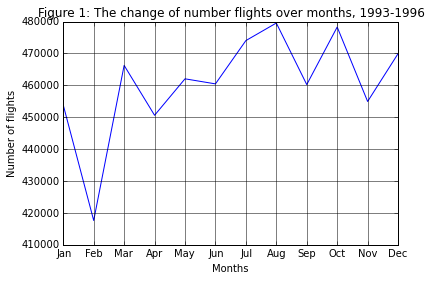

In [89]:
pdf = pd.DataFrame(data=statistic_month)
plt.xlabel("Months")
plt.ylabel("Number of flights")
plt.title('Figure 1: The change of number flights over months, 1993-1996')
plt.grid(True,which="both",ls="-")
plt.plot(pdf[0], pdf[1])
plt.xlim(1,12)
plt.xticks(range(1,13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()

In [68]:
t0 = time.time()
statistic_day_of_week = df.groupBy("day_of_week").count().collect()
t1 = time.time()
print("finish in %f seconds" % (t1-t0))

finish in 8.808654 seconds


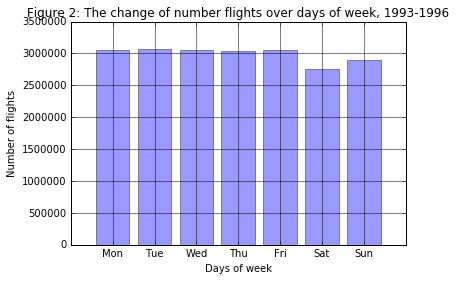

In [72]:
#statistic_day_of_week.show()
pdf = pd.DataFrame(data=statistic_day_of_week)
plt.xlabel("Days of week")
plt.ylabel("Number of flights")
plt.title('Figure 2: The change of number flights over days of week, 1993-1996')
plt.grid(True,which="both",ls="-")
map_int_into_day = { 1:"Mon", 2:"Tue", 3:"Wed", 4:"Thu", 5:"Fri", 6:"Sat", 7:"Sun" }
day_of_week_label = pdf[0].map(lambda i: map_int_into_day[i])

# plot bar chart
plt.bar(pdf[0], pdf[1], align="center", alpha = 0.4)

plt.xticks(pdf[0], day_of_week_label)
plt.show()


In [70]:
t0 = time.time()
statistic_day_of_month = df.groupBy("day_of_month").count().collect()
t1 = time.time()
print("finish in %f seconds" % (t1-t0))

finish in 7.629210 seconds


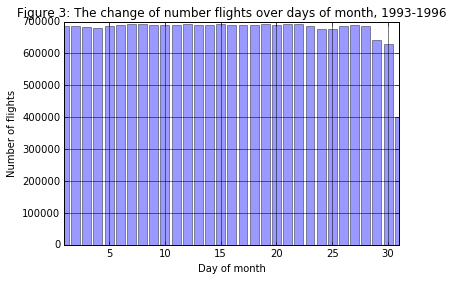

In [73]:
#statistic_day_of_month.show()
pdf = pd.DataFrame(data=statistic_day_of_month)
# plot bar chart
plt.bar(pdf[0], pdf[1], align = 'center', alpha = 0.4)
plt.xlim(1,31)
plt.title("Figure 3: The change of number flights over days of month, 1993-1996")
plt.grid(True, which="both", ls="-")
plt.xlabel("Day of month")
plt.ylabel("Number of flights")
plt.show()

In [74]:
t0 = time.time()
statistic_hour_of_day = df.groupBy("hour").count().collect()
t1 = time.time()
print("finish in %f seconds" % (t1-t0))

finish in 9.714251 seconds


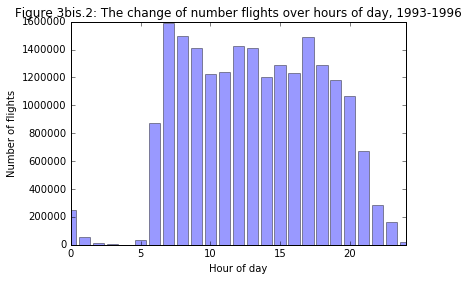

In [76]:
#statistic_hour_of_day.show()
pdf = pd.DataFrame(data=statistic_hour_of_day)

#plot char chart
plt.bar(pdf[0], pdf[1], align="center", alpha=0.4)

plt.title('Figure 3bis.2: The change of number flights over hours of day, 1993-1996')
plt.xlabel("Hour of day")
plt.ylabel("Number of flights")
plt.xlim(0,24)
plt.xticks()
plt.show()

In [78]:
# group by year and hour
statistic_delay_hour = df.groupBy("hour")

# calculate the delay ratio and create a new column
delay_ratio_per_hour = statistic_delay_hour.agg(
    (func.sum('is_delay')/func.count('*')).alias('delay_ratio')
)

    
# order the result by hour
delay_ratio_per_hour = (
            delay_ratio_per_hour
                .orderBy('hour')
                .select(['hour', 'delay_ratio'])
    )

pdf_delay_ratio_per_hour = pd.DataFrame(data=delay_ratio_per_hour.collect())

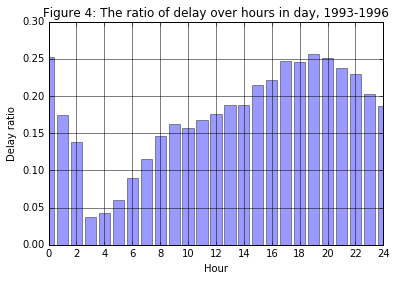

In [80]:
# plot a bar chart
plt.bar(pdf_delay_ratio_per_hour[0], pdf_delay_ratio_per_hour[1], align="center", alpha=0.4)
plt.xlim(0,24)
plt.xlabel('Hour')
plt.ylabel('Delay ratio')
plt.grid(True,which="both",ls="-")
plt.xticks(range(0,25,2), [str(i) for i in range(0,25,2)])
plt.title('Figure 4: The ratio of delay over hours in day, 1993-1996')
plt.show()

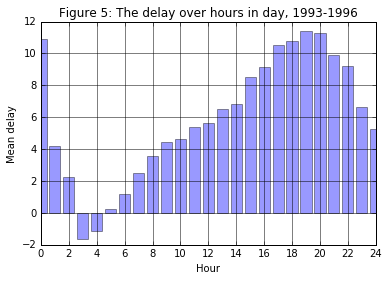

In [84]:
mean_delay_per_hour = statistic_delay_hour.agg(
    (func.mean('arrival_delay')).alias('mean_delay')
)
    
mean_delay_per_hour = (
    mean_delay_per_hour
        .orderBy('hour')
        .select(['hour', 'mean_delay'])
    )
    
pdf_mean_delay_per_hour = pd.DataFrame(data=mean_delay_per_hour.collect())

plt.bar(pdf_mean_delay_per_hour[0], pdf_mean_delay_per_hour[1], align="center", alpha=0.4)
plt.xlim(0,24)
plt.xlabel('Hour')
plt.ylabel('Mean delay')
plt.grid(True,which="both",ls="-")
plt.xticks(range(0,25,2), [str(i) for i in range(0,25,2)])
plt.title('Figure 5: The delay over hours in day, 1993-1996')
plt.show()

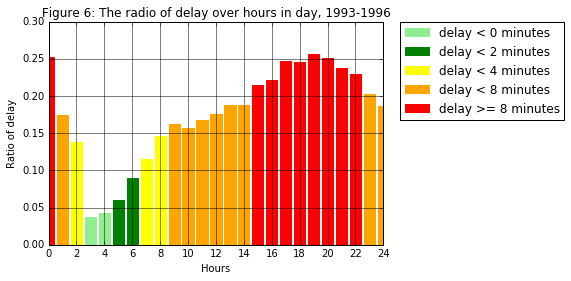

In [83]:
#pdf2 = pd.DataFrame(data=mean_delay_per_hour.collect())
plt.xlabel("Hours")
plt.ylabel("Ratio of delay")
plt.title('Figure 6: The radio of delay over hours in day, 1993-1996')
plt.grid(True,which="both",ls="-")
bars = plt.bar(pdf_delay_ratio_per_hour[0], pdf_delay_ratio_per_hour[1], align='center', edgecolor = "black")
for i in range(0, len(bars)):
    color = 'red'
    if pdf_mean_delay_per_hour[1][i] < 0:
        color = 'lightgreen'
    elif pdf_mean_delay_per_hour[1][i] < 2:
        color = 'green'
    elif pdf_mean_delay_per_hour[1][i] < 4:
        color = 'yellow'
    elif pdf_mean_delay_per_hour[1][i] < 8:
        color = 'orange'
    bars[i].set_color(color)
        
patch1 = mpatches.Patch(color='lightgreen', label='delay < 0 minutes')
patch2 = mpatches.Patch(color='green', label='delay < 2 minutes')
patch3 = mpatches.Patch(color='yellow', label='delay < 4 minutes')
patch4 = mpatches.Patch(color='orange', label='delay < 8 minutes')
patch5 = mpatches.Patch(color='red', label='delay >= 8 minutes')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0,24)
plt.xticks(range(0,25,2), [str(i) for i in range(0,25,2)])
plt.show()

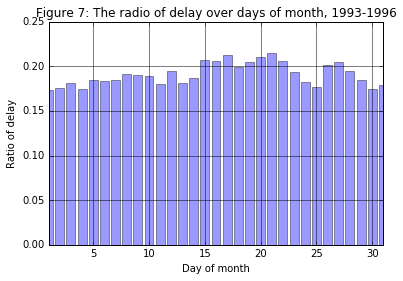

In [86]:
####### The changes of delay ratio over days of month ########
# calculate the delay ratio in each day of month
statistic_day_of_month = (
    df
        .groupBy("day_of_month")
        .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))
        # order by day_of_month
        .orderBy("day_of_month")
    )
    
# collect data and plot
pdf_day_of_month = pd.DataFrame(data=statistic_day_of_month.collect())
plt.bar(pdf_day_of_month[0], pdf_day_of_month[1], align="center", alpha=0.4)
plt.grid(True,which="both",ls="-")
plt.xlabel("Day of month")
plt.ylabel("Ratio of delay")
plt.title('Figure 7: The radio of delay over days of month, 1993-1996')
plt.xlim(1,31)
plt.show()

In [88]:
pdf_day_of_month

,0,1
0,1,0.173002
1,2,0.176019
2,3,0.180677
3,4,0.174695
4,5,0.184183
5,6,0.183185
6,7,0.184383
7,8,0.191018
8,9,0.189649
9,10,0.188676


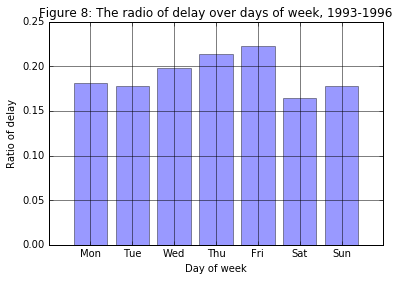

In [89]:
####### The changes of delay ratio over days of week ########
# calculate the delay ratio in each day of week
statistic_day_of_week = (
    df
        .groupBy("day_of_week")
        .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))
        .orderBy("day_of_week")
    )
    
# collect data and plot
pdf_day_of_week = pd.DataFrame(data=statistic_day_of_week.collect())
map_int_into_day = { 1:"Mon", 2:"Tue", 3:"Wed", 4:"Thu", 5:"Fri", 6:"Sat", 7:"Sun" }
day_of_week_label = pdf_day_of_week[0].map(lambda i: map_int_into_day[i])

plt.bar(pdf_day_of_week[0], pdf_day_of_week[1], align="center", alpha=0.4)
plt.grid(True,which="both",ls="-")
plt.xlabel("Day of week")
plt.ylabel("Ratio of delay")
plt.title('Figure 8: The radio of delay over days of week, 1993-1996')
plt.xticks(pdf_day_of_week[0], day_of_week_label)
plt.show()

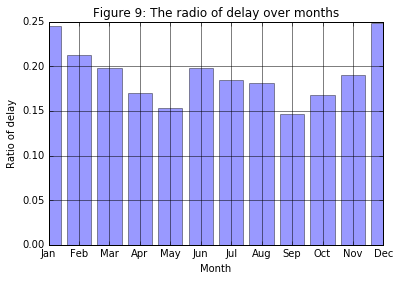

In [90]:
####### The changes of delay ratio over months ########
# calculate the delay ratio in month
statistic_month = (
    df
    .groupBy("month")
    .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))
    .orderBy("month")
    )
    
# collect data and plot
pdf_month = pd.DataFrame(data=statistic_month.collect())
plt.bar(pdf_month[0], pdf_month[1], align="center", alpha=0.4)
plt.grid(True,which="both",ls="-")
plt.xlabel("Month")
plt.ylabel("Ratio of delay")
plt.xlim(1,12)
plt.title('Figure 9: The radio of delay over months, 1993-1996')
plt.xticks(range(1,13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()

## Incidence of departure_delay over arrival_delay

Here, we'll try to see if the delay is caused by incidents before the plane is leaving or if those incidents occures during the flight.

In [9]:
delay_departure_by_minute = df.groupBy("departure_delay")
delay_ratio_per_departure_delay = delay_departure_by_minute.agg(
    (func.sum('arrival_delay')/func.count('*')).alias('average_delay')
)

delay_ratio_per_departure_delay = (
            delay_ratio_per_departure_delay
                .orderBy('departure_delay')
                .select(['departure_delay', 'average_delay'])
    )

pdf_delay_ratio_per_departure_delay = pd.DataFrame(data=delay_ratio_per_departure_delay.collect())

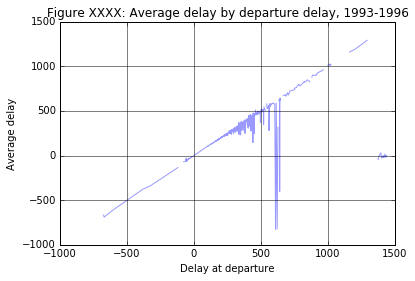

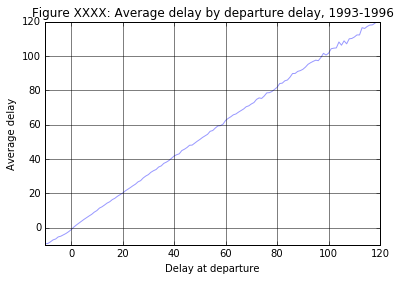

In [105]:
plt.plot(pdf_delay_ratio_per_departure_delay[0], pdf_delay_ratio_per_departure_delay[1], alpha=0.4)
plt.xlabel('Delay at departure')
plt.ylabel('Average delay')
plt.grid(True,which="both",ls="-")
#plt.xticks(range(-10,121,10), [str(i) for i in range(-10,121,10)])
plt.title('Figure XXXX: Average delay by departure delay, 1993-1996')
plt.show()

plt.plot(pdf_delay_ratio_per_departure_delay[0], pdf_delay_ratio_per_departure_delay[1], alpha=0.4)
plt.xlabel('Delay at departure')
plt.ylabel('Average delay')
plt.xlim(-10, 120)
plt.ylim(-10, 120)
plt.grid(True,which="both",ls="-")
#plt.xticks(range(-10,121,10), [str(i) for i in range(-10,121,10)])
plt.title('Figure XXXX: Average delay by departure delay, 1993-1996')
plt.show()

In [57]:
statistic_departure_delay = df.groupBy("departure_delay").count().orderBy("departure_delay").collect()
statistic_arrival_delay = df.groupBy("arrival_delay").count().orderBy("arrival_delay").collect()

pdf_departure_delay = pd.DataFrame(data=statistic_departure_delay)
pdf_arrival_delay = pd.DataFrame(data=statistic_departure_delay)

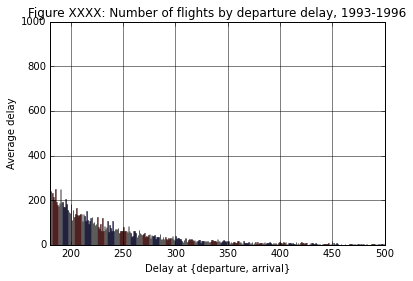

In [62]:
bar_width=0.3
plt.bar(pdf_departure_delay[0], pdf_departure_delay[1], bar_width, align="center", color="blue", alpha=0.4)
plt.bar(pdf_arrival_delay[0]+1.5*bar_width, pdf_arrival_delay[1], bar_width, align="center", color="red", alpha=0.4)

plt.xlabel('Delay at {departure, arrival}')
plt.ylabel('Average delay')
plt.grid(True,which="both",ls="-")
plt.xlim(180, 500)
plt.ylim(0, 1000)
# plt.xticks(range(-10,121,10), [str(i) for i in range(-10,121,10)])
plt.title('Figure XXXX: Number of flights by departure delay, 1993-1996')
plt.show()

In [63]:
total_flights = df.count()
print("During period 1995, among ", total_flights, " flights")
print("\t", df[df.departure_delay>120].count(), "flights departed more than 120 minutes late")
print("\t", df[df.departure_delay<-10].count(), "flight departed more than 10 minutes early")
print("\t", df[df.arrival_delay>120].count(), "flights arrived more than 120 minutes late")
print("\t", df[df.arrival_delay<-10].count(), "flight arrived more than 10 minutes early")

During period 1995, among  5219036  flights
	 40518 flights departed more than 120 minutes late
	 3938 flight departed more than 10 minutes early
	 46641 flights arrived more than 120 minutes late
	 583794 flight arrived more than 10 minutes early


# Does the pilot catch up , 1999

Now we'll try to see how much the plane can reduce the delay of the flight by going faster than usual.

In [106]:
df = df.withColumn("delay_difference", df.departure_delay-df.arrival_delay)
# If delay_difference > 0 that means the pilot caught up

In [107]:
delay_difference_by_distance = df.groupBy("distance")
delay_difference_by_distance = delay_difference_by_distance.agg(
    (func.sum('delay_difference')/func.count('*')).alias('average_delay_difference')
)

delay_difference_by_distance = (
            delay_difference_by_distance
                .orderBy('distance')
                .select(['distance', 'average_delay_difference'])
    )

pdf_delay_difference_by_distance = pd.DataFrame(data=delay_difference_by_distance.collect())

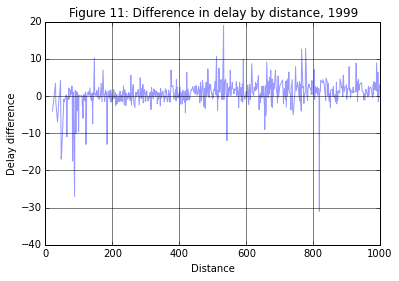

In [108]:
# plot a bar chart
plt.plot(pdf_delay_difference_by_distance[0], pdf_delay_difference_by_distance[1], alpha=0.4)
plt.xlim(0,1000)
plt.xlabel('Distance')
plt.ylabel('Delay difference')
plt.grid(True,which="both",ls="-")
# plt.xticks(range(0,1000,50), [str(i) for i in range(0,1000,50)])
plt.title('Figure 11: Difference in delay by distance, 1999')
plt.show()

# Delay over geographical region, 1999

Here we'll try to see if some regions in the US impose more delay than others:

In [112]:
df_src_airports.select("src_airport_lat").orderBy("src_airport_lat").take(5)

[Row(src_airport_lat=17.701889038085938),
 Row(src_airport_lat=18.337305068969727),
 Row(src_airport_lat=18.439416885375977),
 Row(src_airport_lat=19.738765716552734),
 Row(src_airport_lat=20.898649215698242)]

In [113]:
min_lat = df_src_airports.select("src_airport_lat").orderBy("src_airport_lat").first()
max_lat = df_src_airports.select("src_airport_lat").orderBy("src_airport_lat", ascending=False).first()
min_long = df_src_airports.select("src_airport_long").orderBy("src_airport_long").first()
max_long = df_src_airports.select("src_airport_long").orderBy("src_airport_long", ascending=False).first()

In [114]:
print(min_lat)
print(max_lat)
print(min_long)
print(max_long)

Row(src_airport_lat=17.701889038085938)
Row(src_airport_lat=71.28544616699219)
Row(src_airport_long=-166.5435028076172)
Row(src_airport_long=-64.79855346679688)


In [115]:
worst_airport = (df_with_airports.groupBy("src_airport").
                 agg(func.mean("departure_delay").alias("mean_delay")).orderBy("mean_delay", ascending=False).
                 first()
                 )

In [116]:
df_src_airports[df_src_airports.src_airport_iata=="FCA"].collect()

[Row(src_airport_iata='FCA', src_airport_city='Kalispell', src_airport_state='MT', src_airport_country='USA', src_airport_lat=48.311405181884766, src_airport_long=-114.25506591796875)]

/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


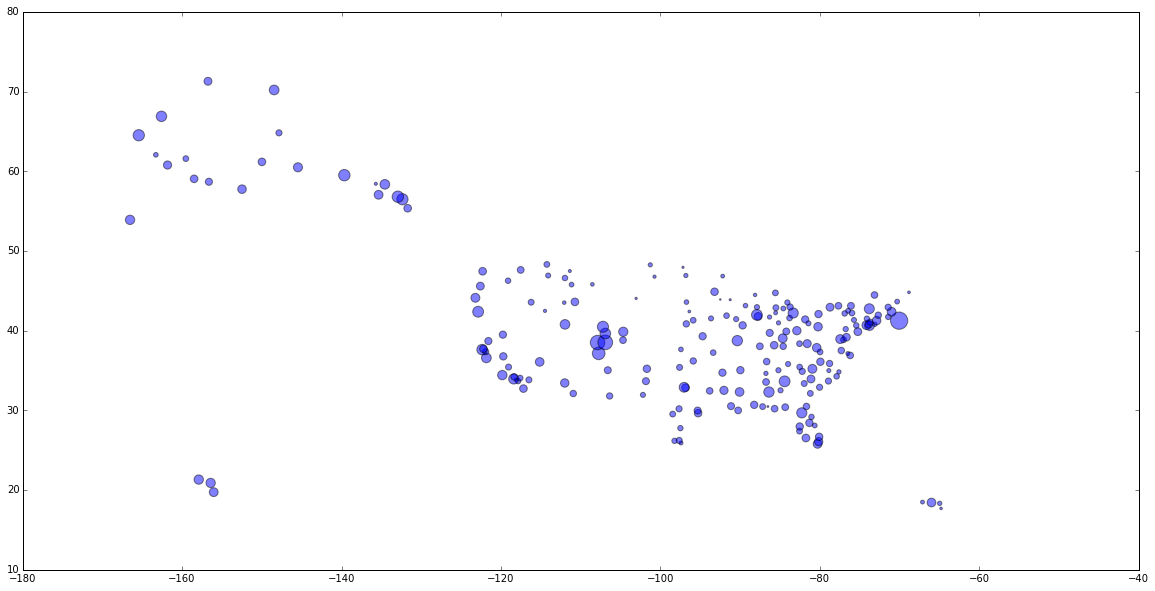

In [55]:
groupby_departure_airport = df.groupBy(["src_airport_lat", "src_airport_long"])
mean_delay_per_airport = groupby_departure_airport.agg(
    (func.mean('departure_delay')).alias('mean_delay')
)
    
mean_delay_per_airport = (
    mean_delay_per_airport
        .orderBy('src_airport_lat')
        .select(['src_airport_lat',"src_airport_long", 'mean_delay'])
    )
    
# pdf_mean_delay_per_airport = pd.DataFrame(data=mean_delay_per_airport.collect())

d = mean_delay_per_airport.mean_delay

minimum = mean_delay_per_airport.select("mean_delay").orderBy("mean_delay").first().mean_delay
maximum = mean_delay_per_airport.select("mean_delay").orderBy("mean_delay", ascending=False).first().mean_delay

mean_delay_per_airport = mean_delay_per_airport[mean_delay_per_airport.mean_delay!=maximum] # ignoring worst airport
mean_delay_per_airport = mean_delay_per_airport.withColumn("normalized_median_delay", (d-minimum)/(maximum-minimum))
pdf_mean_delay_per_airport = pd.DataFrame(data=mean_delay_per_airport.collect())
x = pdf_mean_delay_per_airport[1]
y = pdf_mean_delay_per_airport[0]
area = np.pi * (15 * pdf_mean_delay_per_airport[3])**2  # 0 to 15 point radiuses

plt.figure(figsize=(20,10))
plt.scatter(x, y, s=area, alpha=0.5)
plt.show()

Here we'll try to understand a bit more the delay that can occure during the flight:

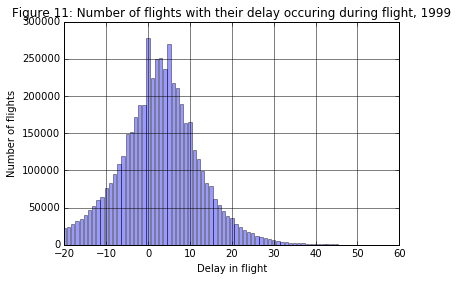

In [82]:
statistic_delay_during_flight = df.groupBy("delay_difference").count().collect()
# collect data and plot
pdf_delay_during_flight = pd.DataFrame(data=statistic_delay_during_flight)
plt.bar(pdf_delay_during_flight[0], pdf_delay_during_flight[1], align="center", alpha=0.4)
plt.grid(True,which="both",ls="-")
plt.xlabel("Delay in flight")
plt.ylabel("Number of flights")
plt.title('Figure 11: Number of flights with their delay occuring during flight, 1999')
plt.xlim(-20,60)
plt.show()

# Add a column n_flights
## TO DO

In [51]:
df_with_airports.groupBy(["src_airport", "year", "month", "day_of_month"])

DataFrame[year: int, month: int, day_of_month: int, day_of_week: int, departure_time: int, scheduled_departure_time: int, arrival_time: int, scheduled_arrival_time: int, arrival_delay: int, departure_delay: int, src_airport: string, dest_airport: string, carrier: string, distance: int]

# Part 4

# First approximation

In [16]:
# select distinct {source airports, destination airports, carriers} and map values to index
# sort the {src_airport, dest_airport, carrier} by their frequency descending
# so the most common {src_aiport, dest_airport, carrier} will be on the top
stat_src = (
    df
        .groupBy("src_airport")
        .agg(func.count("*").alias('count'))
        .orderBy(desc('count'))
    )

stat_dest = (
    df
        .groupBy("dest_airport")
        .agg(func.count("*").alias('count'))
        .orderBy(desc('count'))
    )

stat_carrier = (
    df
        .groupBy("carrier")
        .agg(func.count("*").alias('count'))
        .orderBy(desc('count'))
    )

stat_src_state = (
    df
        .groupBy("src_airport_state")
        .agg(func.count("*").alias('count'))
        .orderBy(desc('count'))
    )

stat_dest_state = (
    df
        .groupBy("dest_airport_state")
        .agg(func.count("*").alias('count'))
        .orderBy(desc('count'))
    )

# extract the {src_airport, dest_airport, carrier} names from {stat_src, stat_dest, stat_carrier}
src_airports = [item[0] for item in stat_src.collect()]
dest_airports = [item[0] for item in stat_dest.collect()]
carriers = [item[0] for item in stat_carrier.collect()]
src_airport_states = [item[0] for item in stat_src_state.collect()]
dest_airport_states = [item[0] for item in stat_dest_state.collect()]

num_src_airports = len(src_airports)
num_dest_airports = len(dest_airports)
num_carriers = len(carriers)
num_src_airport_states = len(src_airport_states)
num_dest_airport_states = len(dest_airport_states)

src_airport_idx = range(0, num_src_airports)
dest_airport_idx = range(0, num_dest_airports)
carrier_idx = range(0, num_carriers)
src_airport_state_idx = range(0, num_dest_airport_states)
dest_airport_state_idx = range(0, num_src_airports)

map_src_airport_to_index = dict(zip(src_airports, src_airport_idx))
map_dest_airport_to_index = dict(zip(dest_airports, dest_airport_idx))
map_carrier_to_index = dict(zip(carriers, carrier_idx))
map_src_airport_state_to_index = dict(zip(src_airport_states, src_airport_state_idx))
map_dest_airport_state_to_index = dict(zip(dest_airport_states, dest_airport_state_idx))

In [17]:
the_most_common_month = (
    df
        .groupBy("month")
        .agg(func.count("*").alias('count'))
        .orderBy(desc('count'))
    ).first()[0]

the_most_common_day_of_month = (
    df
        .groupBy("day_of_month")
        .agg(func.count("*").alias('count'))
        .orderBy(desc('count'))
    ).first()[0]

the_most_common_day_of_week = (
    df
        .groupBy("day_of_week")
        .agg(func.count("*").alias('count'))
        .orderBy(desc('count'))
    ).first()[0]

the_most_common_s_departure_time = (df
        .groupBy("scheduled_departure_time")
        .agg(func.count("*").alias('count'))
        .orderBy(desc('count'))
    ).first()[0]

the_most_common_s_arrival_time =  (df
        .groupBy("scheduled_arrival_time")
        .agg(func.count("*").alias('count'))
        .orderBy(desc('count'))
    ).first()[0]

mean_distance = df.groupBy().agg((func.sum("distance")/func.count("*")).alias("mean")).collect()[0].mean

mean_arrival_delay = df.groupBy().agg((func.sum("arrival_delay")/func.count("*")).alias("mean")).collect()[0].mean

print("The most common month:", the_most_common_month)
print("The most common day of month:", the_most_common_day_of_month)
print("The most common day of week:", the_most_common_day_of_week)
print("The most common scheduled departure time:", the_most_common_s_departure_time)
print("The most common scheduled arrival time:", the_most_common_s_arrival_time)
print("mean distance:", mean_distance)
print("mean arrival delay:", mean_arrival_delay)

The most common month: 3
The most common day of month: 26
The most common day of week: 5
The most common scheduled departure time: 0
The most common scheduled arrival time: 0
mean distance: 696.463770704015
mean arrival delay: 7.02559304055385


In [15]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- departure_time: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- arrival_time: integer (nullable = true)
 |-- scheduled_arrival_time: integer (nullable = true)
 |-- arrival_delay: integer (nullable = true)
 |-- departure_delay: integer (nullable = true)
 |-- src_airport: string (nullable = true)
 |-- dest_airport: string (nullable = true)
 |-- carrier: string (nullable = true)
 |-- distance: integer (nullable = true)
 |-- tail_number: string (nullable = true)
 |-- hour: double (nullable = true)
 |-- is_delay: integer (nullable = false)
 |-- scheduled_departure_minutes: double (nullable = true)
 |-- scheduled_arrival_minutes: double (nullable = true)
 |-- is_WedThuFri: integer (nullable = false)
 |-- is_weekend: integer (nullable = false)
 |-- air_delay: integer (nullable = tru

## First approximation : predict departure_delay

### Test 1 features : day_of_week, scheduled_departure_minutes, carrier, src_airport, is_WedThuFri

In [233]:
data = (df.rdd)\
    .map(lambda row: 
        LabeledPoint( 
            int(row.departure_delay), 
            [
                int(row.day_of_week), # day of week
                int(row.scheduled_departure_minutes), # scheduled departure minutes
                map_carrier_to_index[row.carrier],  # carrier
                map_src_airport_to_index[row.src_airport],  # src_airport
                int(row.is_WedThuFri) # is_WedThuFri
            ]
        )
    )
    

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

trainingData = trainingData.cache()
testData = testData.cache()

# declare information of categorical features
# format:  feature_index : number_distinct_values
categorical_info = {2 : num_carriers, 3: num_src_airports, 4: 2}

In [235]:
t0 = time.time()
# Train a RandomForest model.
forest_model = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo=categorical_info,
                                    numTrees=10, impurity='variance', maxDepth=14, maxBins=255)

predictions_departure_delay = forest_model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions_departure_delay)
bNum_test_data = sc.broadcast(testData.count())
testMSE = labelsAndPredictions.map(
    lambda p: (p[0]-p[1])**2/bNum_test_data.value).reduce(lambda v1,v2: v1+v2)
print('Test Mean Squared Error = ' + str(testMSE))
t1 = time.time()
print("finish in %f seconds" % (t1-t0))

Test Mean Squared Error = 456.8896610261764
finish in 234.525602 seconds


### Test 2 features : day_of_week, scheduled_departure_minutes, carrier, src_airport, is_WedThuFri, src_airport_lat, src_airport_long

In [68]:
data = (df.rdd)\
    .map(lambda row: 
        LabeledPoint( 
            int(row.departure_delay), 
            [
                int(row.day_of_week), # day of week
                int(row.scheduled_departure_minutes), # scheduled departure minutes
                map_carrier_to_index[row.carrier],  # carrier
                map_src_airport_to_index[row.src_airport],  # src_airport
                int(row.is_WedThuFri), # is_WedThuFri
                float(row.src_airport_lat),
                float(row.src_airport_long)
            ]
        )
    )
    

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

trainingData = trainingData.cache()
testData = testData.cache()

# declare information of categorical features
# format:  feature_index : number_distinct_values
categorical_info = {2 : num_carriers, 3: num_src_airports, 4: 2}

In [79]:
from pyspark.mllib.tree import RandomForest, RandomForestModel
t0 = time.time()
# Train a RandomForest model.
forest_model = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo=categorical_info,
                                    numTrees=10, impurity='variance', maxDepth=14, maxBins=255)

predictions_departure_delay = forest_model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions_departure_delay)
bNum_test_data = sc.broadcast(testData.count())
testMSE = labelsAndPredictions.map(
    lambda p: (p[0]-p[1])**2/bNum_test_data.value).reduce(lambda v1,v2: v1+v2)
print('Test Mean Squared Error = ' + str(testMSE))
t1 = time.time()
print("finish in %f seconds" % (t1-t0))

Test Mean Squared Error = 612.135151549906
finish in 320.115255 seconds


In [69]:
from pyspark.mllib.tree import RandomForest, RandomForestModel
t0 = time.time()
# Train a RandomForest model.
forest_model = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo=categorical_info,
                                    numTrees=10, impurity='variance', maxDepth=3, maxBins=255)

predictions_departure_delay = forest_model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions_departure_delay)
bNum_test_data = sc.broadcast(testData.count())
testMSE = labelsAndPredictions.map(
    lambda p: (p[0]-p[1])**2/bNum_test_data.value).reduce(lambda v1,v2: v1+v2)
print('Test Mean Squared Error = ' + str(testMSE))
t1 = time.time()
print("finish in %f seconds" % (t1-t0))

Test Mean Squared Error = 626.0064283880163
finish in 45.693095 seconds


### Test 3 features : day_of_week, scheduled_departure_minutes, carrier, src_airport, src_airport_lat, src_airport_long

In [50]:
data = (df.rdd)\
    .map(lambda row: 
        LabeledPoint( 
            int(row.departure_delay), 
            [
                int(row.day_of_week), # day of week
                int(row.scheduled_departure_minutes), # scheduled departure minutes
                map_carrier_to_index[row.carrier],  # carrier
                map_src_airport_to_index[row.src_airport],  # src_airport
                float(row.src_airport_lat),
                float(row.src_airport_long)
            ]
        )
    )
    

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

trainingData = trainingData.cache()
testData = testData.cache()

# declare information of categorical features
# format:  feature_index : number_distinct_values
categorical_info = {2 : num_carriers, 3: num_src_airports}

In [51]:
from pyspark.mllib.tree import RandomForest, RandomForestModel
t0 = time.time()
# Train a RandomForest model.
forest_model = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo=categorical_info,
                                    numTrees=10, impurity='variance', maxDepth=14, maxBins=255)

predictions_departure_delay = forest_model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions_departure_delay)
bNum_test_data = sc.broadcast(testData.count())
testMSE = labelsAndPredictions.map(
    lambda p: (p[0]-p[1])**2/bNum_test_data.value).reduce(lambda v1,v2: v1+v2)
print('Test Mean Squared Error = ' + str(testMSE))
t1 = time.time()
print("finish in %f seconds" % (t1-t0))

Test Mean Squared Error = 613.9091152264838
finish in 272.688847 seconds


In [52]:
data = (df.rdd)\
    .map(lambda row: 
        LabeledPoint( 
            int(row.departure_delay), 
            [
                int(row.day_of_week), # day of week
                int(row.scheduled_departure_minutes), # scheduled departure minutes
                map_carrier_to_index[row.carrier],  # carrier
                map_src_airport_to_index[row.src_airport],  # src_airport
                float(row.src_airport_lat),
                float(row.src_airport_long)
            ]
        )
    )
    

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

trainingData = trainingData.cache()
testData = testData.cache()

# declare information of categorical features
# format:  feature_index : number_distinct_values
categorical_info = {2 : num_carriers, 3: num_src_airports}

In [53]:
t0 = time.time()
# Train a RandomForest model.
forest_model = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo=categorical_info,
                                    numTrees=10, impurity='variance', maxDepth=30, maxBins=255)

predictions_departure_delay = forest_model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions_departure_delay)
bNum_test_data = sc.broadcast(testData.count())
testMSE = labelsAndPredictions.map(
    lambda p: (p[0]-p[1])**2/bNum_test_data.value).reduce(lambda v1,v2: v1+v2)
print('Test Mean Squared Error = ' + str(testMSE))
t1 = time.time()
print("finish in %f seconds" % (t1-t0))

Test Mean Squared Error = 626.2481677286484
finish in 662.282170 seconds


### Test 4 features : day_of_week, scheduled_departure_minutes, carrier, src_airport, src_airport_state

In [18]:
data = (df.rdd)\
    .map(lambda row: 
        LabeledPoint( 
            int(row.departure_delay), 
            [
                int(row.day_of_week), # day of week
                int(row.scheduled_departure_minutes), # scheduled departure minutes
                map_carrier_to_index[row.carrier],  # carrier
                map_src_airport_to_index[row.src_airport],  # src_airport
                map_src_airport_state_to_index[row.src_airport_state],  # src_airport_state
            ]
        )
    )
    

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

trainingData = trainingData.cache()
testData = testData.cache()

# declare information of categorical features
# format:  feature_index : number_distinct_values
categorical_info = {2 : num_carriers, 3: num_src_airports, 4: num_src_airport_states}

In [257]:
from pyspark.mllib.tree import RandomForest, RandomForestModel
t0 = time.time()
# Train a RandomForest model.
forest_model = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo=categorical_info,
                                    numTrees=10, impurity='variance', maxDepth=14, maxBins=255)

predictions_departure_delay = forest_model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions_departure_delay)
bNum_test_data = sc.broadcast(testData.count())
testMSE = labelsAndPredictions.map(
    lambda p: (p[0]-p[1])**2/bNum_test_data.value).reduce(lambda v1,v2: v1+v2)
print('Test Mean Squared Error = ' + str(testMSE))
t1 = time.time()
print("finish in %f seconds" % (t1-t0))

Test Mean Squared Error = 447.3793826854714
finish in 329.196377 seconds


In [19]:
from pyspark.mllib.tree import RandomForest, RandomForestModel
t0 = time.time()
# Train a RandomForest model.
forest_model = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo=categorical_info,
                                    numTrees=10, impurity='variance', maxDepth=4, maxBins=255)

predictions_departure_delay = forest_model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions_departure_delay)
bNum_test_data = sc.broadcast(testData.count())
testMSE = labelsAndPredictions.map(
    lambda p: (p[0]-p[1])**2/bNum_test_data.value).reduce(lambda v1,v2: v1+v2)
print('Test Mean Squared Error = ' + str(testMSE))
t1 = time.time()
print("finish in %f seconds" % (t1-t0))

Test Mean Squared Error = 641.3511921700017
finish in 61.098859 seconds


## Second approximation : predict air_delay

### Test 5 features : day_of_week, scheduled_arrival_minutes, dest_airport, is_WedThuFri, distance

In [47]:
data = (df.rdd)\
    .map(lambda row: 
        LabeledPoint( 
            int(row.air_delay), 
            [
                int(row.day_of_week), # day of week
                int(row.scheduled_arrival_minutes), # scheduled arrival minutes
                int(row.distance),  # distance
                map_dest_airport_to_index[row.dest_airport],  # dest_airport
                int(row.is_WedThuFri) # is_WedThuFri
            ]
        )
    )
    

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

trainingData = trainingData.cache()
testData = testData.cache()

# declare information of categorical features
# format:  feature_index : number_distinct_values
categorical_info = {3: num_dest_airports, 4: 2}

In [48]:
t0 = time.time()
# Train a RandomForest model.
forest_model = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo=categorical_info,
                                    numTrees=10, impurity='variance', maxDepth=14, maxBins=255)

predictions_air_delay = forest_model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions_air_delay)
bNum_test_data = sc.broadcast(testData.count())
testMSE = labelsAndPredictions.map(
    lambda p: (p[0]-p[1])**2/bNum_test_data.value).reduce(lambda v1,v2: v1+v2)
print('Test Mean Squared Error = ' + str(testMSE))
t1 = time.time()
print("finish in %f seconds" % (t1-t0))

Test Mean Squared Error = 239.1927702319496
finish in 243.781696 seconds


## In the cells below we use some new features about plane data, therefore we need to work on a year posterior to 1994 (year 1994 does not include tail_number), we have chosen year 1995

### Test 6 features : day_of_week, scheduled_arrival_minutes, dest_airport, is_WedThuFri, type_engine, type_aircraft

In [212]:
data = (df.rdd)\
    .map(lambda row: 
        LabeledPoint( 
            int(row.air_delay), 
            [
                int(row.day_of_week), # day of week
                int(row.scheduled_arrival_minutes), # scheduled arrival minutes
                int(row.distance),  # distance
                map_dest_airport_to_index[row.dest_airport],  # dest_airport
                int(row.is_WedThuFri), # is_WedThuFri
                0 if (row.type_engine==None) else int(row.type_engine), # type_engine
                0 if (row.type_aircraft==None) else int(row.type_aircraft)-3 # type_aircraft
            ]
        )
    )
    

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

trainingData = trainingData.cache()
testData = testData.cache()

# declare information of categorical features
# format:  feature_index : number_distinct_values
categorical_info = {3: num_dest_airports, 4: 2, 5: 12, 6: 3}

In [213]:
t0 = time.time()
# Train a RandomForest model.
forest_model = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo=categorical_info,
                                    numTrees=10, impurity='variance', maxDepth=14, maxBins=255)

predictions_air_delay = forest_model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions_air_delay)
bNum_test_data = sc.broadcast(testData.count())
testMSE = labelsAndPredictions.map(
    lambda p: (p[0]-p[1])**2/bNum_test_data.value).reduce(lambda v1,v2: v1+v2)
print('Test Mean Squared Error = ' + str(testMSE))
t1 = time.time()
print("finish in %f seconds" % (t1-t0))

Test Mean Squared Error = 245.93803446626373
finish in 268.223931 seconds


### Test 7 features : day_of_week, scheduled_arrival_minutes, distance, dest_airport, is_WedThuFri, type_engine, type_aircraft, dest_airport_state

In [229]:
data = (df.rdd)\
    .map(lambda row: 
        LabeledPoint( 
            int(row.air_delay), 
            [
                int(row.day_of_week), # day of week
                int(row.scheduled_arrival_minutes), # scheduled arrival minutes
                int(row.distance),  # distance
                map_dest_airport_to_index[row.dest_airport],  # dest_airport
                int(row.is_WedThuFri), # is_WedThuFri
                0 if (row.type_engine==None) else int(row.type_engine), # type_engine
                0 if (row.type_aircraft==None) else int(row.type_aircraft)-3, # type_aircraft
                map_dest_airport_state_to_index[row.dest_airport_state]
            ]
        )
    )
    

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

trainingData = trainingData.cache()
testData = testData.cache()

# declare information of categorical features
# format:  feature_index : number_distinct_values
categorical_info = {3: num_dest_airports, 4: 2, 5: 12, 6: 3, 7: num_dest_airport_states}

In [230]:
t0 = time.time()
# Train a RandomForest model.
forest_model = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo=categorical_info,
                                    numTrees=10, impurity='variance', maxDepth=14, maxBins=255)

predictions_air_delay = forest_model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions_air_delay)
bNum_test_data = sc.broadcast(testData.count())
testMSE = labelsAndPredictions.map(
    lambda p: (p[0]-p[1])**2/bNum_test_data.value).reduce(lambda v1,v2: v1+v2)
print('Test Mean Squared Error = ' + str(testMSE))
t1 = time.time()
print("finish in %f seconds" % (t1-t0))

Test Mean Squared Error = 237.6697641749721
finish in 291.635124 seconds


### Test 8 features : day_of_week, scheduled_arrival_minutes, distance, dest_airport, is_WedThuFri, type_engine, type_aircraft, dest_airport_lat, dest_airport_long

In [20]:
data = (df.rdd)\
    .map(lambda row: 
        LabeledPoint( 
            int(row.air_delay), 
            [
                int(row.day_of_week), # day of week
                int(row.scheduled_arrival_minutes), # scheduled arrival minutes
                int(row.distance),  # distance
                map_dest_airport_to_index[row.dest_airport],  # dest_airport
                int(row.is_WedThuFri), # is_WedThuFri
                0 if (row.type_engine==None) else int(row.type_engine), # type_engine
                0 if (row.type_aircraft==None) else int(row.type_aircraft)-3, # type_aircraft
                float(row.dest_airport_lat), # dest_airport_lat
                float(row.dest_airport_long) # dest_airport_long
            ]
        )
    )
    

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

trainingData = trainingData.cache()
testData = testData.cache()

# declare information of categorical features
# format:  feature_index : number_distinct_values
categorical_info = {3: num_dest_airports, 4: 2, 5: 12, 6: 3}

In [232]:
t0 = time.time()
# Train a RandomForest model.
forest_model = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo=categorical_info,
                                    numTrees=10, impurity='variance', maxDepth=14, maxBins=255)

predictions_air_delay = forest_model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions_air_delay)
bNum_test_data = sc.broadcast(testData.count())
testMSE = labelsAndPredictions.map(
    lambda p: (p[0]-p[1])**2/bNum_test_data.value).reduce(lambda v1,v2: v1+v2)
print('Test Mean Squared Error = ' + str(testMSE))
t1 = time.time()
print("finish in %f seconds" % (t1-t0))

Test Mean Squared Error = 241.06016105103953
finish in 315.069328 seconds


In [21]:
t0 = time.time()
# Train a RandomForest model.
forest_model = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo=categorical_info,
                                    numTrees=10, impurity='variance', maxDepth=4, maxBins=255)

predictions = forest_model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)
bNum_test_data = sc.broadcast(testData.count())
testMSE = labelsAndPredictions.map(
    lambda p: (p[0]-p[1])**2/bNum_test_data.value).reduce(lambda v1,v2: v1+v2)
print('Test Mean Squared Error = ' + str(testMSE))
t1 = time.time()
print("finish in %f seconds" % (t1-t0))

Test Mean Squared Error = 264.1403526721934
finish in 50.674737 seconds


### Test 9 features : day_of_week, scheduled_arrival_minutes, distance, dest_airport, type_engine, type_aircraft, is_weekend

In [96]:
data = (df.rdd)\
    .map(lambda row: 
        LabeledPoint( 
            int(row.air_delay), 
            [
                int(row.day_of_week), # day of week
                int(row.scheduled_arrival_minutes), # scheduled arrival minutes
                int(row.distance),  # distance
                map_dest_airport_to_index[row.dest_airport],  # dest_airport
                int(row.is_WedThuFri), # is_WedThuFri
                0 if (row.type_engine==None) else int(row.type_engine), # type_engine
                0 if (row.type_aircraft==None) else int(row.type_aircraft)-3 # type_aircraft
            ]
        )
    )
    

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

trainingData = trainingData.cache()
testData = testData.cache()

# declare information of categorical features
# format:  feature_index : number_distinct_values
categorical_info = {3: num_dest_airports, 4: 2, 5: 12, 6: 3}

In [34]:
t0 = time.time()
# Train a RandomForest model.
forest_model = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo=categorical_info,
                                    numTrees=10, impurity='variance', maxDepth=14, maxBins=255)

predictions_air_delay = forest_model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions_air_delay)
bNum_test_data = sc.broadcast(testData.count())
testMSE = labelsAndPredictions.map(
    lambda p: (p[0]-p[1])**2/bNum_test_data.value).reduce(lambda v1,v2: v1+v2)
print('Test Mean Squared Error = ' + str(testMSE))
t1 = time.time()
print("finish in %f seconds" % (t1-t0))

Test Mean Squared Error = 243.65578096755576
finish in 270.082523 seconds


In [97]:
t0 = time.time()
# Train a RandomForest model.
forest_model = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo=categorical_info,
                                    numTrees=10, impurity='variance', maxDepth=4, maxBins=255)

predictions_air_delay = forest_model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions_air_delay)
bNum_test_data = sc.broadcast(testData.count())
testMSE = labelsAndPredictions.map(
    lambda p: (p[0]-p[1])**2/bNum_test_data.value).reduce(lambda v1,v2: v1+v2)
print('Test Mean Squared Error = ' + str(testMSE))
t1 = time.time()
print("finish in %f seconds" % (t1-t0))

Test Mean Squared Error = 253.0267796417641
finish in 47.134536 seconds


### Test 10 features : scheduled_arrival_minutes, distance, dest_airport

In [19]:
from pyspark.mllib.tree import RandomForest, RandomForestModel
t0 = time.time()
# Train a RandomForest model.
forest_model = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo=categorical_info,
                                    numTrees=10, impurity='variance', maxDepth=4, maxBins=255)

predictions_departure_delay = forest_model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions_departure_delay)
bNum_test_data = sc.broadcast(testData.count())
testMSE = labelsAndPredictions.map(
    lambda p: (p[0]-p[1])**2/bNum_test_data.value).reduce(lambda v1,v2: v1+v2)
print('Test Mean Squared Error = ' + str(testMSE))
t1 = time.time()
print("finish in %f seconds" % (t1-t0))

Test Mean Squared Error = 641.3511921700017
finish in 61.098859 seconds


In [76]:
data = (df.rdd)\
    .map(lambda row: 
        LabeledPoint( 
            int(row.air_delay), 
            [
                int(row.scheduled_arrival_minutes), # scheduled arrival minutes
                int(row.distance),  # distance
                map_dest_airport_to_index[row.dest_airport]  # dest_airport
            ]
        )
    )
    
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

trainingData = trainingData.cache()
testData = testData.cache()

# declare information of categorical features
# format:  feature_index : number_distinct_values
categorical_info = {2: num_dest_airports}

In [77]:
t0 = time.time()
# Train a RandomForest model.
forest_model = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo=categorical_info,
                                    numTrees=10, impurity='variance', maxDepth=14, maxBins=255)

predictions_air_delay = forest_model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions_air_delay)
bNum_test_data = sc.broadcast(testData.count())
testMSE = labelsAndPredictions.map(
    lambda p: (p[0]-p[1])**2/bNum_test_data.value).reduce(lambda v1,v2: v1+v2)
print('Test Mean Squared Error = ' + str(testMSE))
t1 = time.time()
print("finish in %f seconds" % (t1-t0))

Test Mean Squared Error = 250.01506384390868
finish in 123.269305 seconds


### Test 11 features : day_of_month

In [70]:
data = df.rdd

data = (df.rdd)\
    .map(lambda row: 
        LabeledPoint( 
            int(row.air_delay), 
            [
                int(row.day_of_month), # day_of_month
            ]
        )
    )
    
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

trainingData = trainingData.cache()
testData = testData.cache()

# declare information of categorical features
# format:  feature_index : number_distinct_values
categorical_info = {}

In [94]:
t0 = time.time()
# Train a RandomForest model.
forest_model = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo=categorical_info,
                                    numTrees=10, impurity='variance', maxDepth=6, maxBins=255)

predictions_air_delay = forest_model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions_air_delay)
bNum_test_data = sc.broadcast(testData.count())
testMSE = labelsAndPredictions.map(
    lambda p: (p[0]-p[1])**2/bNum_test_data.value).reduce(lambda v1,v2: v1+v2)
print('Test Mean Squared Error = ' + str(testMSE))
t1 = time.time()
print("finish in %f seconds" % (t1-t0))

Test Mean Squared Error = 249.122093057951
finish in 38.663921 seconds


blabla

In [71]:
t0 = time.time()
# Train a RandomForest model.
forest_model = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo=categorical_info,
                                    numTrees=10, impurity='variance', maxDepth=6, maxBins=255)

predictions_air_delay = forest_model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions_air_delay)
bNum_test_data = sc.broadcast(testData.count())
testMSE = labelsAndPredictions.map(
    lambda p: (p[0]-p[1])**2/bNum_test_data.value).reduce(lambda v1,v2: v1+v2)
print('Test Mean Squared Error = ' + str(testMSE))
t1 = time.time()
print("finish in %f seconds" % (t1-t0))

Test Mean Squared Error = 253.5227906566311
finish in 38.432927 seconds


## Prediction_departure + prediction_air

In [82]:
data = df.rdd
(trainingData, testData) = data.randomSplit([0.7, 0.3])

trainingData = trainingData.cache()
testData = testData.cache()

train_data_departure = (trainingData)\
    .map(lambda row: 
        LabeledPoint( 
            int(row.departure_delay), 
            [
                int(row.day_of_week), # day of week
                int(row.scheduled_departure_minutes), # scheduled departure minutes
                map_carrier_to_index[row.carrier],  # carrier
                map_src_airport_to_index[row.src_airport],  # src_airport
                map_src_airport_state_to_index[row.src_airport_state],  # src_airport_state
            ]
        )
    )
    
test_data_departure = (testData)\
    .map(lambda row: 
        LabeledPoint( 
            int(row.departure_delay), 
            [
                int(row.day_of_week), # day of week
                int(row.scheduled_departure_minutes), # scheduled departure minutes
                map_carrier_to_index[row.carrier],  # carrier
                map_src_airport_to_index[row.src_airport],  # src_airport
                map_src_airport_state_to_index[row.src_airport_state],  # src_airport_state
            ]
        )
    )

# declare information of categorical features
# format:  feature_index : number_distinct_values
categorical_info = {2 : num_carriers, 3: num_src_airports, 4: num_src_airport_states}

In [83]:
t0 = time.time()
# Train a RandomForest model.
forest_model = RandomForest.trainRegressor(train_data_departure, categoricalFeaturesInfo=categorical_info,
                                    numTrees=10, impurity='variance', maxDepth=4, maxBins=255)

predictions_departure_delay = forest_model.predict(test_data_departure.map(lambda x: x.features))
labelsAndPredictions = test_data_departure.map(lambda lp: lp.label).zip(predictions_departure_delay)
bNum_test_data = sc.broadcast(test_data_departure.count())
testMSE = labelsAndPredictions.map(
    lambda p: (p[0]-p[1])**2/bNum_test_data.value).reduce(lambda v1,v2: v1+v2)
print('Test Mean Squared Error = ' + str(testMSE))
t1 = time.time()
print("finish in %f seconds" % (t1-t0))

Test Mean Squared Error = 643.2690617627397
finish in 54.831914 seconds


In [86]:
test_data_air = (testData)\
    .map(lambda row: 
        LabeledPoint( 
            int(row.air_delay), 
            [
                int(row.day_of_month), # day_of_month
            ]
        )
    )
    
training_data_air = (trainingData)\
    .map(lambda row: 
        LabeledPoint( 
            int(row.air_delay), 
            [
                int(row.day_of_month), # day_of_month
            ]
        )
    )
    
categorical_info = {}

In [87]:
t0 = time.time()
# Train a RandomForest model.
forest_model = RandomForest.trainRegressor(training_data_air, categoricalFeaturesInfo=categorical_info,
                                    numTrees=10, impurity='variance', maxDepth=6, maxBins=255)

predictions_air_delay = forest_model.predict(test_data_air.map(lambda x: x.features))
labelsAndPredictions = test_data_air.map(lambda lp: lp.label).zip(predictions_air_delay)
bNum_test_data = sc.broadcast(test_data_air.count())
testMSE = labelsAndPredictions.map(
    lambda p: (p[0]-p[1])**2/bNum_test_data.value).reduce(lambda v1,v2: v1+v2)
print('Test Mean Squared Error = ' + str(testMSE))
t1 = time.time()
print("finish in %f seconds" % (t1-t0))

Test Mean Squared Error = 266.15117219031004
finish in 24.373456 seconds


In [99]:
t0 = time.time()
predictions_total = predictions_air_delay.zip(predictions_departure_delay)
predictions_total = predictions_total.map(lambda p: p[0]+p[1])
labelsAndPredictions = testData.map(lambda lp: lp.arrival_delay).zip(predictions_total)
bNum_test_data = sc.broadcast(testData.count())
testMSE = labelsAndPredictions.map(
    lambda p: (p[0]-p[1])**2/bNum_test_data.value).reduce(lambda v1,v2: v1+v2)
print('Test Mean Squared Error = ' + str(testMSE))
t1 = time.time()
print("finish in %f seconds" % (t1-t0))

Test Mean Squared Error = 668.2586313649962
finish in 358.565121 seconds


/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


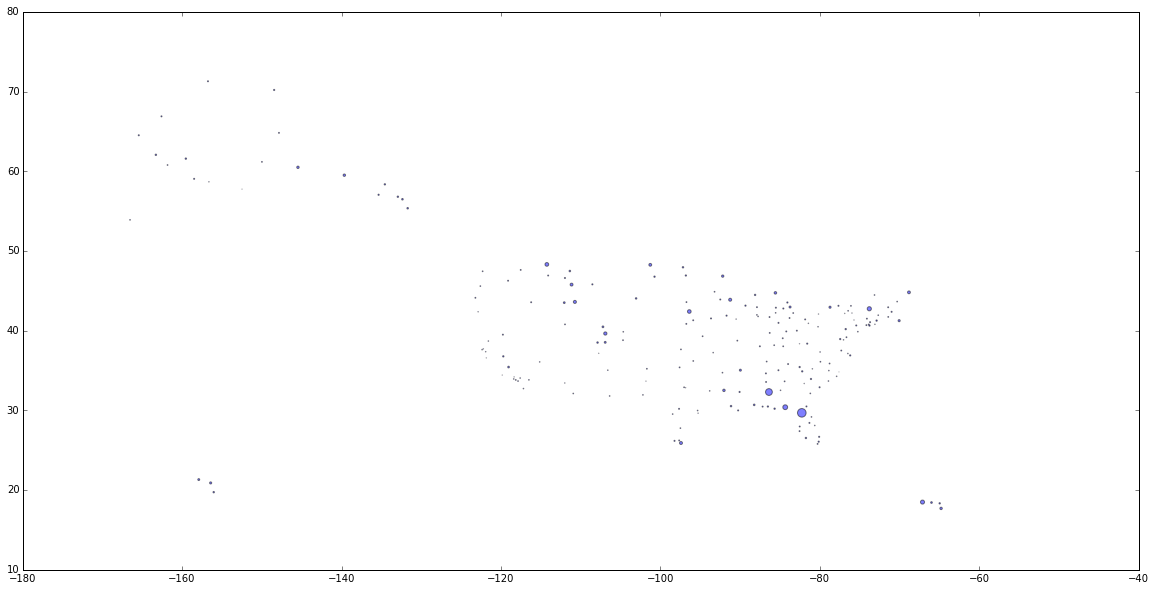

In [56]:
mean_delay_per_airport = df.filter(df.departure_delay>=60).groupBy(["src_airport_lat", "src_airport_long"]).agg(
    (func.mean('departure_delay')).alias('mean_delay')
)
    
mean_delay_per_airport = (
    mean_delay_per_airport
        .orderBy('src_airport_lat')
        .select(['src_airport_lat',"src_airport_long", 'mean_delay'])
    )
    
# pdf_mean_delay_per_airport = pd.DataFrame(data=mean_delay_per_airport.collect())

d = mean_delay_per_airport.mean_delay

minimum = mean_delay_per_airport.select("mean_delay").orderBy("mean_delay").first().mean_delay
maximum = mean_delay_per_airport.select("mean_delay").orderBy("mean_delay", ascending=False).first().mean_delay

mean_delay_per_airport = mean_delay_per_airport[mean_delay_per_airport.mean_delay!=maximum] # ignoring worst airport
mean_delay_per_airport = mean_delay_per_airport.withColumn("normalized_median_delay", (d-minimum)/(maximum-minimum))
pdf_mean_delay_per_airport = pd.DataFrame(data=mean_delay_per_airport.collect())
x = pdf_mean_delay_per_airport[1]
y = pdf_mean_delay_per_airport[0]
area = np.pi * (15 * pdf_mean_delay_per_airport[3])**2  # 0 to 15 point radiuses

plt.figure(figsize=(20,10))
plt.scatter(x, y, s=area, alpha=0.5)
plt.show()